# Ensemble Model Prediction
Combine all models and predict with a ensemble approach

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy
import json
import seaborn as sns
from collections import namedtuple
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
import joblib
import matplotlib.pyplot as plt

### Basic values

In [2]:
model_path = 'Choesn_model/'
configure_file_path = 'Choesn_model/Configuration.json'

TRAINFILE = 'keyword.csv'
TESTFILE = 'key_word_test.csv'
boolean = 'True'

## MODEL object
```class Model(object)``` records information of each model to ensemble

In [3]:
class Model(object):

    def  __init__(self, model, name, test_set, topic, is_preprocess, level):
        self.model = model
        self.name = name
        self.test_set = test_set
        self.topic = topic
        self.is_preprocess = is_preprocess
        self.level = level
        self.encoding = None

    # for debug use
    def show(self):
        print(
            self.name,'\t',
            self.test_set,'\t',
            self.topic,'\t',
            self.is_preprocess,'\t',
            self.level
        )

    def predict(self, x):
        if self.level == 1:
            pred_y = self.model.predict(x)
            for i in range(pred_y.shape[0]):
                pred_y[i] = self.convert(str(pred_y[i]))
            
            return pred_y.astype(int)
        else:
            return self.model.predict(x)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

    def set_encoding(self, encoding):
        self.encoding = encoding

    def convert(self, x):
        return int(self.encoding[x])

# Load model details from ```.json``` configuration file
create model objects from ```.json``` file

In [4]:
def load_configuration_to_model(file_path):
    '''
    Load the json file and figure the parameter of each model

    Return: (Tuple Object) with two sub-list
            sub-list_1: Model for layer one (For revelent and irrevelent)
            sub-list_2: Model for layer two (For topic decision)
    '''

    with open(configure_file_path, 'r') as json_fp:
        configuration = json.load(json_fp)

    layer_1 = []
    layer_2 = []
    
    for model_figure in configuration:

        # read the figure
        model_file = joblib.load(model_path + model_figure['model_name'])
        name = model_figure['model_name']
        test_set = model_figure['test_set']
        topic = model_figure['topic']
        is_preprocess = boolean == model_figure['preprocess']
        level = int(model_figure['level'])

        # New model object to save those arguments
        model = Model(model_file, name, test_set, topic, is_preprocess, level)

        # append to model list for futher processing
        if level == 1:
            model.set_encoding(model_figure['encoding'])
            layer_1.append(model)
        elif level == 2:
            layer_2.append(model)

    return layer_1,layer_2

## Prepare testing data and preprocess vectors

In [5]:
def get_vector(column_name, special=False):
    '''
    df                      str: The train df
    fit_column              str: The column for vector to fit

    Return: (Vectorizer Object)
            Vectorizer of current column
    '''
    train_df = pd.read_csv(TRAINFILE)
    if special is not False:
        train_df = train_df.dropna()
        train_df[special] = train_df[special].apply(lambda x: x.replace('_', ''))

    # prepare the tranform vector
    vector = TfidfVectorizer().fit(train_df[column_name])

    return vector

def preprocess(df, column_name_list):
    '''
    This function to use to prepare all the data for ensemble system running
    including RAW data and Vector-preprocess data

    Return: (Dict object)
            A after preprocessing data dict, it order by column_name_list
        
            ext:
            Input: column_name_list: ['key_word_100', 'article_words']
            Output: test_data_dict: test_data_dict['key_word_100'] --> key_word_100
                                    test_data_dict['article_words'] -> article_words
                                    test_data_dict['raw']          --> original data
    '''

    test_data_dict = {}

    # first add original data
    test_data_dict['raw'] = df

    vector = get_vector('article_words', special='article_words')
    
    for column in column_name_list:
        en_data = vector.transform(df[column])
        test_data_dict[str(column)] = en_data

    # for special data, add it by manul
    vector = get_vector('key_word_100')
    test_data_dict['key_word_100_1'] = vector.transform(df['key_word_100'])

    return test_data_dict

In [6]:
df = pd.read_csv(TESTFILE)
dict_data = preprocess(df, ['key_word_100', 'article_words'])

In [6]:
df = pd.read_csv(TRAINFILE)
dict_data = preprocess(df, ['key_word_100', 'article_words'])

## Ensemble part

### Load lists of models

In [7]:
model_list_1, model_list_2 = load_configuration_to_model(configure_file_path)

### Utilisation function and values for ensemble model

In [8]:
# create a Vote structure include following information:
#    model: which model votes             - int
#    cate:  which category it votes       - int
#    proba: the probability it provides   - float
Vote = namedtuple("Vote", "model cate proba")

In [9]:
topic_list = list(set(df['topic']))
topic_list.sort()

def create_encode(topics):
    encode_list = dict()
    decode_list = dict()

    for num, topic in enumerate(topics):
        decode_list[num] = topic
        encode_list[topic] = num
        
    return encode_list, decode_list

topic_encode, topic_decode = create_encode(topic_list)
sample_size = len(df)

In [10]:
def create_weights(topics):
    topic_count = {}
    for topic in topics:
        topic_count[topic] = 0

    for model in model_list_1 + model_list_2:
        for topic in model.topic:
            topic_count[topic] += 1
    return [topic_count[max(topic_count)]/i for i in topic_count.values()]

weight_list = create_weights(topic_list)

### ensemble core code

In [18]:
def vote_proba(votes, topic_dict, weights=None):
    cate_count = len(topic_dict)

    column_names = ['predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)

    for num, sample in enumerate(votes): 
        # vote_list to count vote, init with 11 zeros
        vote_list = [[] for _ in range(cate_count)]
        vote_probas = [[] for _ in range(cate_count)]
        for vote in sample:
            vote_list[vote.cate].append(vote.model)
            vote_probas[vote.cate].append(vote.proba)
        vote_count = [len(cate_list) for cate_list in vote_list]
        vote_proba_mean = [0 for _ in range(cate_count)]
        for i in range(cate_count):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
                
        if weights is not None:
            for i in range(len(vote_count)):
                vote_count[i] *= weights[i]
            
        # get category chosen by vote
        max_vote = max(vote_count)
        
        # if no vote, create None column, else, create column by vote.
        if max_vote == 0:
            res = ['IRRELEVANT', None, None, None]
        else:
            # check count
            # if draw vote, check proba
            if vote_list.count(max_vote) > 1:
                chosen_cate = vote_proba_mean.index(max(vote_proba_mean))

            # if not draw
            else:
                chosen_cate = vote_count.index(max_vote)

            # append to result DataFrame
            res = [topic_dict[chosen_cate], vote_proba_mean[chosen_cate], vote_list[chosen_cate], vote_probas[chosen_cate]]
        new_row = pd.Series(res, index=column_names)
        df = df.append(new_row, ignore_index=True)
        
    return df

In [19]:
def irre_vote(model_list, sample_size):
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
            if clf.is_preprocess is True:
                test_x = dict_data[clf.test_set]
            else:
                test_x = dict_data['raw'][clf.test_set]
            y_pred = clf.predict(test_x)
            y_pred_proba = clf.predict_proba(test_x)
            for i in range(sample_size):
                cate, proba = y_pred[i], y_pred_proba[i]

                clf_name = clf.name.split('.')[0]
                # create namedtuple (model_name, category, category_proba)
                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    topic_dict = {0: 'IRRELEVANT', 1: 'RELEVANT'}
    return vote_proba(all_votes, topic_dict)

In [20]:
def cate_vote(model_list, sample_size, irre_res, truth):
    global weight_list
    
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    final_df = pd.DataFrame(columns = column_names)
    
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        if clf.is_preprocess is True:
            test_x = dict_data[clf.test_set]
        else:
            test_x = dict_data['raw'][clf.test_set]
        y_pred = clf.predict(test_x)
        y_pred_proba = clf.predict_proba(test_x)
        for i in range(sample_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            if topic_decode[cate] in clf.topic:
                            
                clf_name = clf.name.split('.')[0]

                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    rela_res = vote_proba(all_votes, topic_decode, weight_list)
    for i in range(sample_size):
        if irre_res['predict'].iloc[i] == 'IRRELEVANT':
            final_res = [truth[i]] + irre_res.iloc[i].tolist()
        else:
            final_res = [truth[i]] + rela_res.iloc[i].tolist()
        new_row = pd.Series(final_res, index=column_names)
        final_df = final_df.append(new_row, ignore_index=True)

    return final_df

In [21]:
res_df = cate_vote(model_list_2, sample_size, irre_vote(model_list_1, sample_size), df['topic'])
res_df = res_df.set_index(df.article_number)

In [22]:
res_df.head(5)

,label,predict,mean_proba,models,probas
article_number,,,,,
1,FOREX MARKETS,FOREX MARKETS,0.980599,"[tfidf_logi_pipe, clf_NB_1, svm_proba_1, svm_p...","[0.9999892477564003, 1.0, 0.9702737087020363, ..."
2,MONEY MARKETS,FOREX MARKETS,0.820673,"[tfidf_logi_pipe, clf_NB_1, svm_proba_1, svm_p...","[0.7744544245625812, 0.9999722802314702, 0.841..."
3,SPORTS,SPORTS,0.907607,"[tfidf_logi_pipe, svm_proba_2, 1_article_words...","[0.8587902530547364, 0.6792429335992182, 1.0, ..."
4,FOREX MARKETS,FOREX MARKETS,0.938563,"[tfidf_logi_pipe, clf_NB_1, svm_proba_1, svm_p...","[0.9824190931451063, 0.9999999999076863, 0.960..."
5,IRRELEVANT,SPORTS,0.970931,"[tfidf_logi_pipe, clf_NB_1, clf_NB_2, svm_prob...","[0.8709676503626803, 1.0, 1.0, 0.9987087029007..."


## Evaluation

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.77      0.73      0.75       117
BIOGRAPHIES PERSONALITIES PEOPLE       0.70      0.74      0.72       167
                         DEFENCE       0.86      0.90      0.88       258
                DOMESTIC MARKETS       0.84      0.74      0.79       133
                   FOREX MARKETS       0.49      0.77      0.60       845
                          HEALTH       0.82      0.84      0.83       183
                      IRRELEVANT       0.97      0.92      0.95      4734
                   MONEY MARKETS       0.74      0.62      0.68      1673
          SCIENCE AND TECHNOLOGY       0.80      0.69      0.74        70
                  SHARE LISTINGS       0.90      0.90      0.90       218
                          SPORTS       0.95      0.98      0.96      1102

                        accuracy                           0.85      9500
             

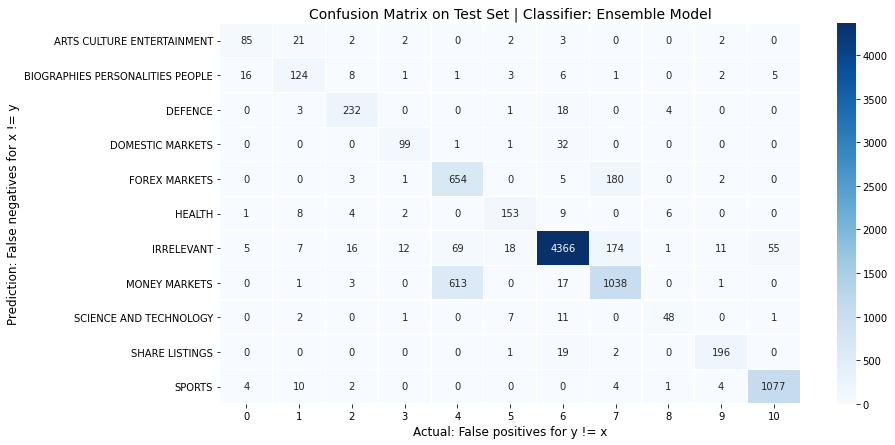

ARTS CULTURE ENTERTAINMENT accuarcy is: 	 0.7264957264957265
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is: 	 0.7425149700598802
DEFENCE accuarcy is: 				 0.8992248062015504
DOMESTIC MARKETS accuarcy is: 			 0.7443609022556391
FOREX MARKETS accuarcy is: 			 0.7739644970414201
HEALTH accuarcy is: 				 0.8360655737704918
IRRELEVANT accuarcy is: 			 0.9222644697929869
MONEY MARKETS accuarcy is: 			 0.620442319187089
SCIENCE AND TECHNOLOGY accuarcy is: 		 0.6857142857142857
SHARE LISTINGS accuarcy is: 			 0.8990825688073395
SPORTS accuarcy is: 				 0.9773139745916516


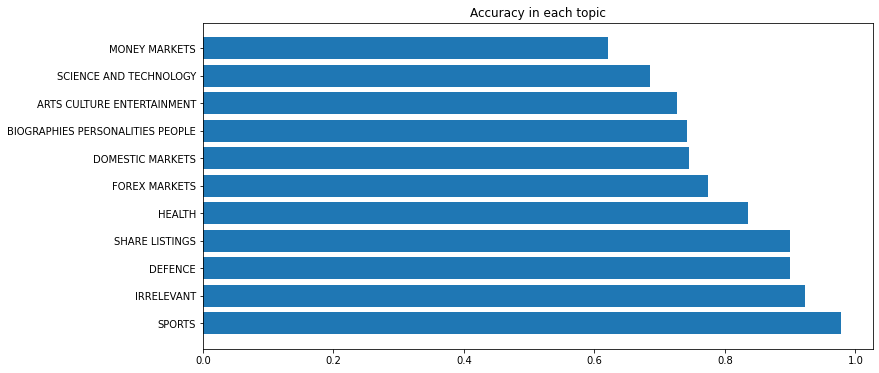

In [23]:
def report(res_df, y_true_label, y_pred_label):
    '''
    Here is for the evaluate the ensamble model

    Input: (DataFrame Object) Should be result of the prediction
    Output: 
    '''
    global topic_list

    test_y = res_df[y_true_label]
    y_pred = res_df[y_pred_label]
    
    print(f"Classification Report:\n{classification_report(test_y, y_pred)}")
    conf_matrix = confusion_matrix(test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,7))
    sns.heatmap(conf_matrix,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=topic_list,
                cmap="Blues",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: Ensemble Model", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

    report = []
    for topic in topic_list:

        # prepare the record
        topic_report = {}
        topic_report['name'] = str(topic)

        # prepare the evaluate data
        test_df = res_df[test_y == topic]

        #evaluate each part
        topic_report['f1_score'] = metrics.f1_score(test_df[y_true_label], test_df[y_pred_label], average='macro')
        topic_report['accuracy'] = metrics.accuracy_score(test_df[y_true_label], test_df[y_pred_label])
        topic_report['recall_score'] = metrics.recall_score(test_df[y_true_label], test_df[y_pred_label], average='macro')
        print(topic,'accuarcy is:', '\t'* (5-(len(topic)+6)//8), topic_report['accuracy'])

        # append t total report for further
        report.append(topic_report)
        

    # sort the report for plt
    report.sort(reverse=True, key=lambda x: x['accuracy'])

    #plt.style.use('ggplot')
    figure = plt.figure(figsize=(12,6))
    #plt.xticks(rotation=90)
    plt.title('Accuracy in each topic')
    plt.barh([i['name'] for i in report], [j['accuracy'] for j in report])

    plt.show()

report(res_df, 'label', 'predict')

## Recomandation

In [24]:
# recommandation
for topic in topic_list:
    if topic != "IRRELEVANT":
        df_filter = res_df[res_df['predict'] == topic]
        
        print(topic)
        recom_article = df_filter.sort_values(by="mean_proba").head(10).index.tolist()
        recom_article.sort()
        print(recom_article)

ARTS CULTURE ENTERTAINMENT
[816, 5521, 5545, 6237, 6333, 7034, 7349, 7779, 8563, 9267]
BIOGRAPHIES PERSONALITIES PEOPLE
[563, 747, 3272, 3548, 4214, 5229, 7108, 7555, 7822, 9395]
DEFENCE
[1438, 2354, 2501, 5576, 6041, 7135, 7257, 7649, 8756, 9032]
DOMESTIC MARKETS
[1278, 3498, 3836, 3990, 4660, 4858, 5388, 5605, 7341, 7502]
FOREX MARKETS
[1062, 1694, 2493, 2626, 3045, 3574, 4914, 5174, 6271, 7176]
HEALTH
[43, 134, 980, 1152, 1504, 2381, 4874, 5710, 6512, 8523]
MONEY MARKETS
[355, 627, 3368, 4602, 5263, 6156, 6994, 7546, 8639, 9276]
SCIENCE AND TECHNOLOGY
[2022, 2917, 4603, 4953, 4962, 5284, 5767, 6604, 8107, 8636]
SHARE LISTINGS
[6, 3688, 3999, 4023, 5723, 6207, 7318, 7484, 7834, 8415]
SPORTS
[504, 1224, 1819, 4462, 4756, 6260, 6442, 7917, 9105, 9168]


In [25]:
for topic in topic_list:
    if topic != "IRRELEVANT":
        df_filter = res_df[res_df['predict'] == topic]
        
        print(topic)
        print('\t', end='')
        print('\n\t'.join(df_filter.sort_values(by="mean_proba").head(10).label.values))

ARTS CULTURE ENTERTAINMENT
	ARTS CULTURE ENTERTAINMENT
	BIOGRAPHIES PERSONALITIES PEOPLE
	ARTS CULTURE ENTERTAINMENT
	BIOGRAPHIES PERSONALITIES PEOPLE
	IRRELEVANT
	SPORTS
	BIOGRAPHIES PERSONALITIES PEOPLE
	ARTS CULTURE ENTERTAINMENT
	SPORTS
	ARTS CULTURE ENTERTAINMENT
BIOGRAPHIES PERSONALITIES PEOPLE
	ARTS CULTURE ENTERTAINMENT
	MONEY MARKETS
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
	DEFENCE
	BIOGRAPHIES PERSONALITIES PEOPLE
	ARTS CULTURE ENTERTAINMENT
	ARTS CULTURE ENTERTAINMENT
	SPORTS
	BIOGRAPHIES PERSONALITIES PEOPLE
DEFENCE
	FOREX MARKETS
	MONEY MARKETS
	MONEY MARKETS
	ARTS CULTURE ENTERTAINMENT
	DEFENCE
	HEALTH
	MONEY MARKETS
	FOREX MARKETS
	SPORTS
	DEFENCE
DOMESTIC MARKETS
	DOMESTIC MARKETS
	BIOGRAPHIES PERSONALITIES PEOPLE
	DOMESTIC MARKETS
	ARTS CULTURE ENTERTAINMENT
	DOMESTIC MARKETS
	DOMESTIC MARKETS
	HEALTH
	DOMESTIC MARKETS
	DOMESTIC MARKETS
	DOMESTIC MARKETS
FOREX MARKETS
	MONEY MARKETS
	MONEY MARKETS
	MONEY MARKETS
	MONEY MARKETS
	MONEY MARKETS

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.40      0.44      0.42         9
BIOGRAPHIES PERSONALITIES PEOPLE       0.40      0.36      0.38        11
                         DEFENCE       0.20      0.50      0.29         4
                DOMESTIC MARKETS       0.70      0.88      0.78         8
                   FOREX MARKETS       0.20      0.22      0.21         9
                          HEALTH       0.50      0.45      0.48        11
                      IRRELEVANT       0.00      0.00      0.00         3
                   MONEY MARKETS       0.50      0.29      0.37        17
          SCIENCE AND TECHNOLOGY       0.50      0.62      0.56         8
                  SHARE LISTINGS       0.80      1.00      0.89         8
                          SPORTS       0.70      0.58      0.64        12

                        accuracy                           0.49       100
             

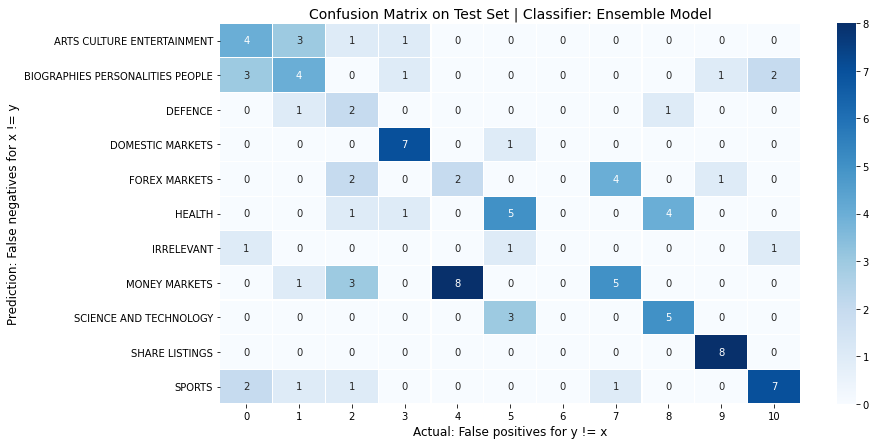

ARTS CULTURE ENTERTAINMENT accuarcy is: 	 0.4444444444444444
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is: 	 0.36363636363636365
DEFENCE accuarcy is: 				 0.5
DOMESTIC MARKETS accuarcy is: 			 0.875
FOREX MARKETS accuarcy is: 			 0.2222222222222222
HEALTH accuarcy is: 				 0.45454545454545453
IRRELEVANT accuarcy is: 			 0.0
MONEY MARKETS accuarcy is: 			 0.29411764705882354
SCIENCE AND TECHNOLOGY accuarcy is: 		 0.625
SHARE LISTINGS accuarcy is: 			 1.0
SPORTS accuarcy is: 				 0.5833333333333334


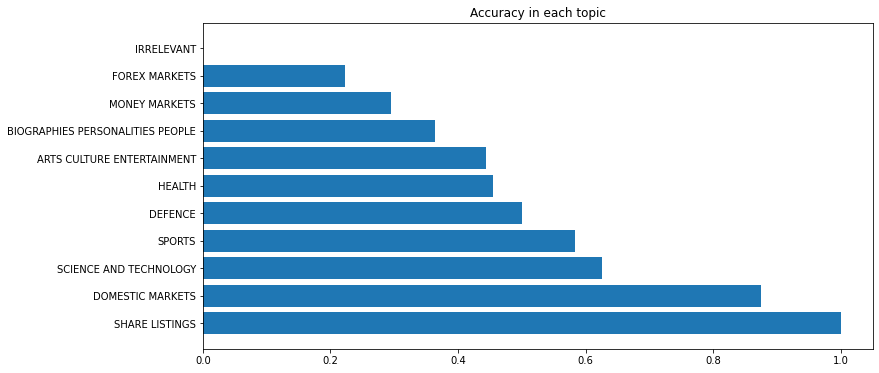

In [26]:
article_list = []
for topic in topic_list: 
    if topic != "IRRELEVANT":
        df_filter = res_df[res_df['predict'] == topic]
        
        article_list += df_filter.sort_values(by="mean_proba").head(10).index.tolist()
article_list.sort()
report(res_df.loc[article_list, :], 'label', 'predict')